In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics.pairwise import cosine_similarity

import os
import zipfile
import cv2
import shutil
import random
from PIL import Image


import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version: ", sys.version)
print("Tensorflow Version: ", tf.__version__)

# DEFINED
BATCH_SIZE = 32
IMG_WIDTH  = 224
IMG_HEIGHT = 224


Python Version:  3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version:  2.16.1


In [2]:
# Load model
model = keras.models.load_model("../TrainingModels/VGG.keras")

In [3]:
furniture_df = pd.read_csv("../furniture_data.csv")
shuffled_furniture_df = furniture_df.sample(frac=1).reset_index(drop=True)

shutil.copy(shuffled_furniture_df['Image_Path'].iloc[0], "../ImageTesting/Task 2")

'../ImageTesting/Task 2\\23400transitional-dining-chairs.jpg'

C:\Users\CYBER\Desktop\Furniture-Classification-Model-main\ImageTesting\Task 2\24919transitional-armchairs-and-accent-chairs.jpg is a .jpg file


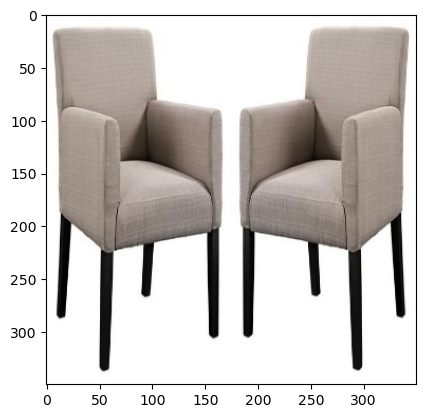

In [4]:
input_image_path = input("Please Input Your Image Location: ")
input_image_path.replace('\\', '/')

# Get the file extension from the file path
file_ext = os.path.splitext(input_image_path)[1]

# Check if the file extension is ".jpg"
if file_ext.lower() == ".jpg":
    correct_image_path = input_image_path
    plt.imshow(Image.open(input_image_path))
    print(f"{input_image_path} is a .jpg file")
else:
    print(f"{input_image_path} is not a .jpg file")

In [5]:
def prepare(filepath):
    img_array = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    new_array = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
    return np.expand_dims(new_array, axis=0).repeat(BATCH_SIZE, axis=0)

dataset_categories = furniture_df["Furniture_Category"].unique()

# Predict input image
prediction = model.predict(prepare(correct_image_path))

predicted_class_index = np.argmax(prediction, axis=1)

# Get type of data with in the same from user input and reset index after getting all items
types_predict_dataset = furniture_df[furniture_df['Furniture_Category'] == dataset_categories[predicted_class_index[0]]]['Image_Path']
types_predict_dataset.reset_index(inplace=True, drop=True)

types_predict_dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


0        ../Furniture_Data\chairs\Asian\13989asian-dini...
1        ../Furniture_Data\chairs\Asian\13990asian-fold...
2        ../Furniture_Data\chairs\Asian\13991asian-indo...
3        ../Furniture_Data\chairs\Asian\13992asian-fold...
4        ../Furniture_Data\chairs\Asian\13993asian-fold...
                               ...                        
22048    ../Furniture_Data\chairs\Victorian\5016victori...
22049    ../Furniture_Data\chairs\Victorian\5130victori...
22050    ../Furniture_Data\chairs\Victorian\5446victori...
22051    ../Furniture_Data\chairs\Victorian\5502victori...
22052    ../Furniture_Data\chairs\Victorian\8779victori...
Name: Image_Path, Length: 22053, dtype: object

In [6]:
# Load and process input image
input_image = Image.open(correct_image_path).convert('RGB')
input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
input_vector = np.array(input_image).ravel().reshape(1, -1)

# Load and process dataset images using list comprehension
dataset_vectors = np.array([
    np.array(Image.open(path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))).ravel() 
    for path in types_predict_dataset
])

In [7]:
dataset_vectors

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [8]:
input_vector

array([[255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [9]:
# Define batch size
batch_size = 1000

# Calculate similarity scores in batches
similarity_scores = np.empty((len(input_vector), len(dataset_vectors))) # Pre-allocate memory
for i in range(0, len(dataset_vectors), batch_size):
    similarity_scores[:, i:i+batch_size] = cosine_similarity(
        input_vector, dataset_vectors[i:i+batch_size]
    )

In [10]:
flattened_similarity_scores = similarity_scores.flatten()

flattened_similarity_scores

array([0.86513929, 0.90406814, 0.92365737, ..., 0.89644679, 0.8178305 ,
       0.92909408])

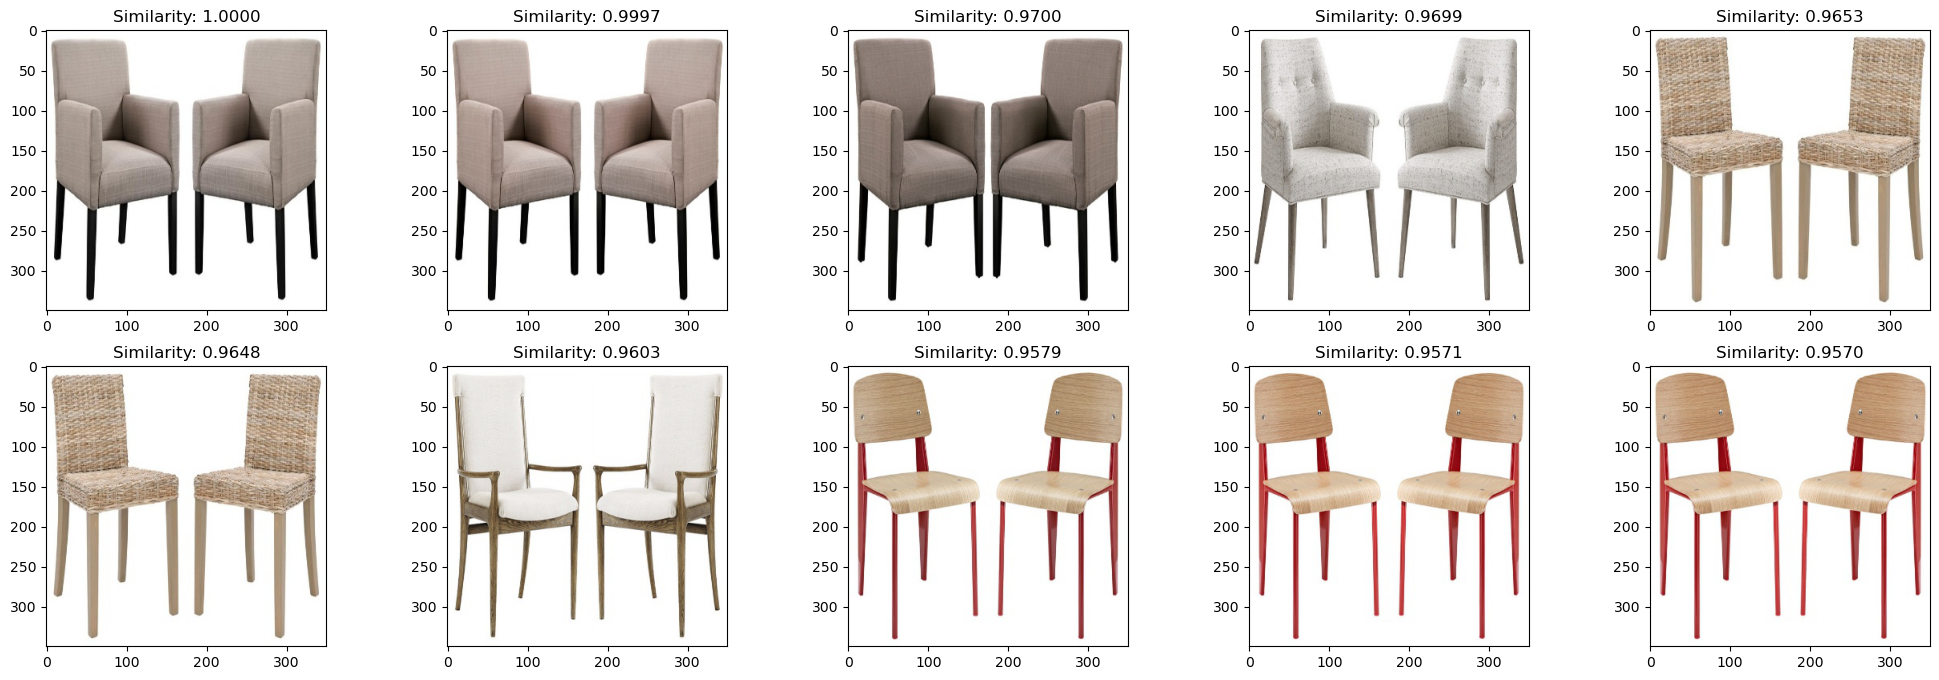

In [11]:
# Get the top 10 most similar image indices directly
top_indices = np.argsort(similarity_scores.ravel())[-10:][::-1]  # Get top 10 in descending order

# Get paths of the top 10 most similar images
top_paths = types_predict_dataset.iloc[top_indices]

# Display the top 10 most similar images and their scores
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 8))
for i, ax in enumerate(axes.flat):
    image_path = top_paths.iloc[i]  
    similarity_score = similarity_scores.ravel()[top_indices[i]]

    ax.imshow(Image.open(image_path))
    ax.set_title(f"Similarity: {similarity_score:.4f}")
plt.show()